# Sentence Transformer

Будем использовать предобученную модель, из библиотеки sentence-transformers. Лучшее качество, в нашей задаче, из всех моделей показала модель sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2. Будем использовать ее с помощью библиотеки sentence-transformers.

In [1]:
import sys
import os
import warnings

import pandas as pd
from sentence_transformers import SentenceTransformer
from datasets import load_dataset, Features, Value
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
import optuna

warnings.filterwarnings('ignore')

# Добавляем в path вышестоящую директорию для импорта  calc_metrics
sys.path.append(os.path.abspath(os.path.join("..")))

from utils import calc_metrics

c:\Users\user\miniconda3\envs\ml_yp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
metrics = pd.read_csv('metrics.csv', index_col=0)

Загрузим модель, данные и каждый текст пропустим через модель и получим эмбеддинги.

In [3]:
model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

feature = Features({"release": Value("string")})
dataset = load_dataset("csv", data_files="../data/x.csv", features=feature)
texts = dataset["train"]["release"]
embeddings = model.encode(texts, normalize_embeddings=True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"  

Generating train split: 101 examples [00:00, 4601.42 examples/s]


In [4]:
# загрузим таргет
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

Теперь полученные эмбеддинги подадим на вход модели классического ML. Подберем гиперпараметры, и модель.

In [5]:
def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 25),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 25),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 25),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_features": trial.suggest_int("max_features", 10, 384),
    }

    # определяем pipeline
    pipeline = Pipeline(
        [
            (
                "model",
                RandomForestClassifier(
                    max_depth=params["max_depth"],
                    max_features=params["max_features"],
                    min_samples_leaf=params["min_samples_leaf"],
                    min_samples_split=params["min_samples_split"],
                    n_estimators=params["n_estimators"],
                    random_state=42,
                    n_jobs=-1,
                ),
            ),
        ]
    )

    # считаем метрики на кросс валидации
    metric, _ = calc_metrics(
        embeddings,
        y,
        pipeline,
        name=" ",
        plot=False,
        calc_jobs=-1,
    )

    return metric


# устанавливаем уровень логирования optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# запускаем подбор гиперпараметров
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

Best trial: 131. Best value: 0.823791: 100%|██████████| 200/200 [10:58<00:00,  3.29s/it]


Пробовали обучить модель K-ближайших соседей, линейную регрессию, бустинг, но лучшее качество показал Случайный лес.

In [6]:
study.best_params

{'max_depth': 8,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 150,
 'max_features': 137}

Обучим модель с лучшими параметрами и посмотрим на результаты

              precision    recall  f1-score   support

        -1.0       0.75      0.62      0.68        24
         0.0       0.56      0.64      0.60        28
         1.0       0.74      0.74      0.74        19

    accuracy                           0.66        71
   macro avg       0.68      0.67      0.67        71
weighted avg       0.67      0.66      0.66        71



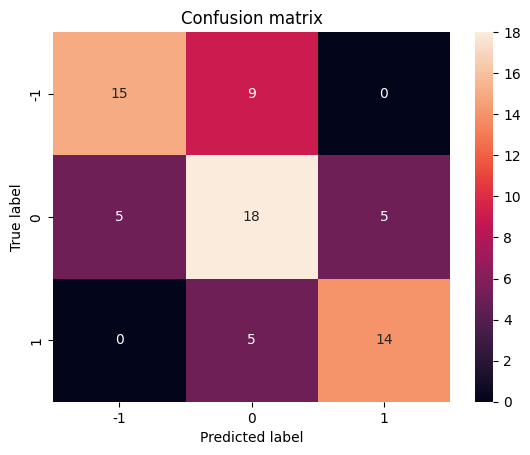

In [7]:
pipeline = Pipeline(
    [
        (
            "model",
            RandomForestClassifier(
                max_depth=study.best_params["max_depth"],
                max_features=study.best_params["max_features"],
                min_samples_leaf=study.best_params["min_samples_leaf"],
                min_samples_split=study.best_params["min_samples_split"],
                n_estimators=study.best_params["n_estimators"],
                random_state=42,
                n_jobs=-1,
            ),
        ),
    ]
)

# считаем метрики на кросс валидации
metric, _ = calc_metrics(
    embeddings,
    y,
    pipeline,
    name="Sentence transformer",
    plot=True,
    calc_jobs=-1,
)

In [11]:
metrics = pd.concat([metrics, metric], axis=0)
metrics

,accuracy,f1,recall,precision,roc_auc_ovr,roc_auc_ovo
Sentence transformer,0.661972,0.672887,0.668233,0.683114,0.815232,0.823791


In [12]:
metrics.to_csv('metrics.csv')